Change the loss function to Tversky

In [1]:
# Data Processing and Visualization
import os
import random
import glob
import re

# Data Manipulation and Analysis
import numpy as np
import pandas as pd
import math

# Image Processing and Visualization
import matplotlib.pyplot as plt
import cv2
from skimage import io
from PIL import Image

# Deep Learning Framework (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input
)
from tensorflow.keras.models import Model

# Specific TensorFlow/Keras Components
from tensorflow.keras import layers, optimizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, 
    EarlyStopping, 
    ModelCheckpoint, 
    LearningRateScheduler
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow.keras.backend as K

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
from IPython.display import display
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import binary_crossentropy


Datamap imports the path of images and store them to a variable

In [2]:
datamap = []

# Specify the path to your dataset on your Windows machine
dataset_path = "Dataset_MRI"

# Iterate over subdirectories in the specified path
for sub_dir_path in glob.glob(dataset_path + "/*"):
    # Check if the current path is a directory
    if os.path.isdir(sub_dir_path):
        # Extract the tumor type from the directory name
        dir_name = os.path.basename(sub_dir_path)

        # Iterate over files in the directory
        for filename in os.listdir(sub_dir_path):
            # Construct the full path to the image file
            image_path = os.path.join(sub_dir_path, filename)
            
            # Load the image as an array
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            
            # Check if the image is successfully loaded
            if image is not None:
                # Append a dictionary to the datamap
                datamap.append({
                    'tumor_type': dir_name,
                    'file_name': filename,
                    'file_path': image_path,  # Include the full file path
                    'image': image
                })

# Display the datamap
for entry in datamap[:10]:  # Display only the first 10 entries
    print(f"Tumor Type: {entry['tumor_type']}, File Name: {entry['file_name']}, File Path: {entry['file_path']}, Image Shape: {entry['image'].shape}")


Tumor Type: Astrocytoma, File Name: 0.png, File Path: Dataset_MRI\Astrocytoma\0.png, Image Shape: (630, 630, 3)
Tumor Type: Astrocytoma, File Name: 1.png, File Path: Dataset_MRI\Astrocytoma\1.png, Image Shape: (630, 630, 3)
Tumor Type: Astrocytoma, File Name: 10.png, File Path: Dataset_MRI\Astrocytoma\10.png, Image Shape: (630, 536, 3)
Tumor Type: Astrocytoma, File Name: 2.png, File Path: Dataset_MRI\Astrocytoma\2.png, Image Shape: (630, 512, 3)
Tumor Type: Astrocytoma, File Name: 3.png, File Path: Dataset_MRI\Astrocytoma\3.png, Image Shape: (630, 630, 3)
Tumor Type: Astrocytoma, File Name: 4.png, File Path: Dataset_MRI\Astrocytoma\4.png, Image Shape: (630, 586, 3)
Tumor Type: Astrocytoma, File Name: 5.png, File Path: Dataset_MRI\Astrocytoma\5.png, Image Shape: (630, 630, 3)
Tumor Type: Astrocytoma, File Name: 6.png, File Path: Dataset_MRI\Astrocytoma\6.png, Image Shape: (630, 536, 3)
Tumor Type: Astrocytoma, File Name: 7.png, File Path: Dataset_MRI\Astrocytoma\7.png, Image Shape: (630

Coverting the datamap to dataframe

In [3]:
(3)
# Convert the data_map to a pandas DataFrame Display the first few rows
datamap_df = pd.DataFrame(datamap)
print(datamap_df.head())
# print(df)

    tumor_type file_name                       file_path  \
0  Astrocytoma     0.png   Dataset_MRI\Astrocytoma\0.png   
1  Astrocytoma     1.png   Dataset_MRI\Astrocytoma\1.png   
2  Astrocytoma    10.png  Dataset_MRI\Astrocytoma\10.png   
3  Astrocytoma     2.png   Dataset_MRI\Astrocytoma\2.png   
4  Astrocytoma     3.png   Dataset_MRI\Astrocytoma\3.png   

                                               image  
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
2  [[[10, 10, 10], [10, 10, 10], [11, 11, 11], [1...  
3  [[[5, 5, 5], [5, 5, 5], [5, 5, 5], [6, 6, 6], ...  
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  


Displaying the images before pre-processing

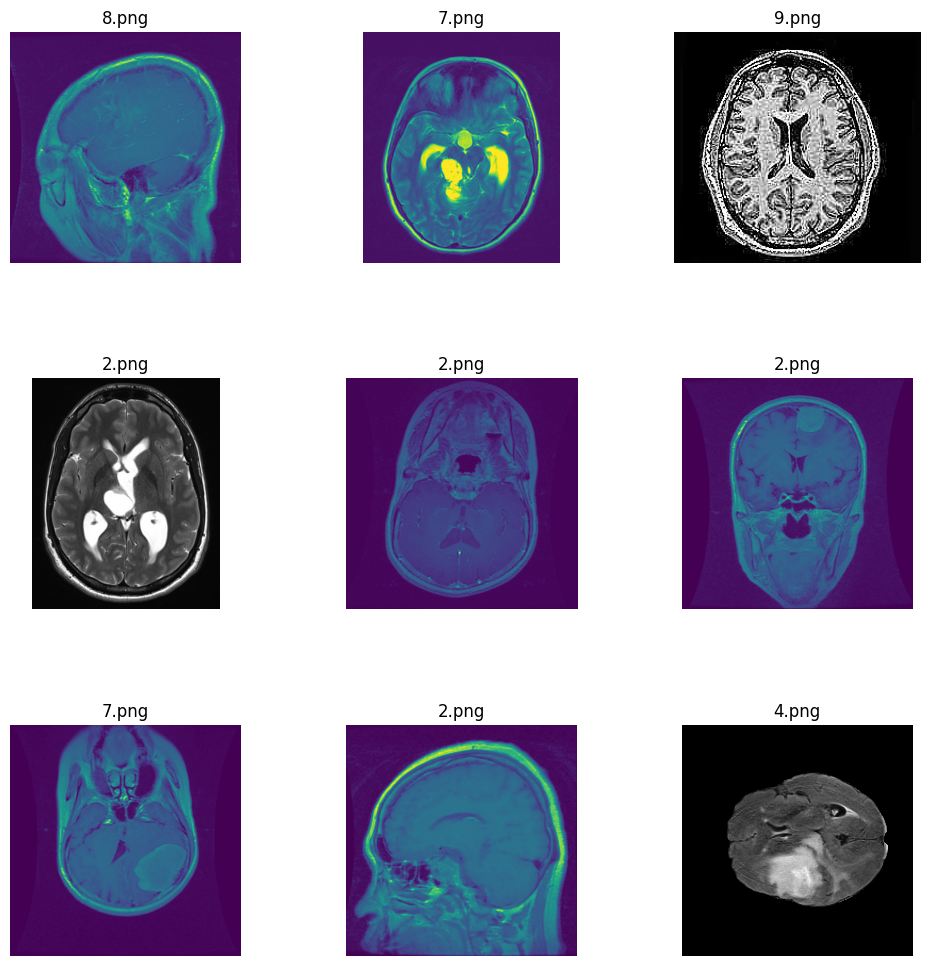

In [4]:
(4)
# Fixed number of images to display and columns
num_images_to_display = 9
num_cols = 3
num_rows = 3  # Since num_images_to_display is 9 and num_cols is 3

# Create a new figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Select random rows from the DataFrame
random_rows = datamap_df.sample(n=num_images_to_display)

# Iterate through the randomly selected rows to display images
for idx, (index, row) in enumerate(random_rows.iterrows()):
    # Determine the current row and column for the subplot
    current_row, current_col = divmod(idx, num_cols)

    # Load and display the image
    img = Image.open(row['file_path'])
    axes[current_row, current_col].imshow(img)
    axes[current_row, current_col].set_title(row['file_name'])
    axes[current_row, current_col].axis('off')

# Hide any empty subplots if necessary
for i in range(idx + 1, num_rows * num_cols):
    axes[i // num_cols, i % num_cols].axis('off')

# Adjust subplot spacing and display the figure
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()


Split data into training, testing, validation

In [5]:
(5)
# Import necessary libraries for splitting data
from sklearn.model_selection import train_test_split
import pandas as pd

# Split your data into training and validation sets
train_df, val_df = train_test_split(datamap_df, test_size=0.2, random_state=42)

# Ensure file paths are strings
train_df['file_path'] = train_df['file_path'].astype(str)
val_df['file_path'] = val_df['file_path'].astype(str)

# train_df and val_df are now ready for use
print("Size of train_df:", len(train_df))
print("Size of val_df:", len(val_df))


Size of train_df: 60
Size of val_df: 16


In [6]:
(6)

# Tumor type labels mapping
tumor_labels = {
    'no_tumor': 0,
    'Gliomas': 1,
    'Meningiomas': 2,
    'Pituitary_Tumor': 3,
    'Astrocytoma': 4,
    'Glioblastoma': 5,
    'Tumor_Type_6': 6
}

# Apply tumor type labels to the DataFrame
train_df['encoded_labels'] = train_df['tumor_type'].map(tumor_labels)
val_df['encoded_labels'] = val_df['tumor_type'].map(tumor_labels)

# Instantiate a LabelEncoder
label_encoder = LabelEncoder()

#Apply tumor type labels to the DataFrame
train_df['encoded_labels'] = train_df['tumor_type'].map(tumor_labels)
val_df['encoded_labels'] = val_df['tumor_type'].map(tumor_labels)

# Fit and transform the labels in the training set
train_df['encoded_labels'] = label_encoder.fit_transform(train_df['tumor_type'])

# Transform the labels in the validation set
val_df['encoded_labels'] = label_encoder.transform(val_df['tumor_type'])

train_image_paths = train_df['file_path'].tolist()
train_labels = train_df['encoded_labels'].tolist()

val_image_paths = val_df['file_path'].tolist()
val_labels = val_df['encoded_labels'].tolist()

Data Generator

In [7]:
(7)
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, image_size, num_classes, augmenter=None, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.augmenter = augmenter  # For image augmentation
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[k] for k in batch_indices]
        batch_labels = [self.labels[k] for k in batch_indices]
        X, y = self.__generate_Xy(batch_image_paths, batch_labels)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __generate_Xy(self, batch_image_paths, batch_labels):
        X = np.empty((self.batch_size, *self.image_size, 3))
        y = np.empty((self.batch_size, *self.image_size, self.num_classes))

        for i, (path, label) in enumerate(zip(batch_image_paths, batch_labels)):
            image = cv2.imread(path)

            # Ensure the image has 3 channels (convert grayscale to RGB if needed)
            if len(image.shape) == 2 or image.shape[2] == 1:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

            # Resize the image to the specified size
            image = cv2.resize(image, self.image_size)
            X[i,] = image / 255.0

            label_matrix = np.zeros((*self.image_size, self.num_classes))
            label_matrix[:, :, int(label)] = 1  # Convert label to categorical
            y[i,] = label_matrix

        return X, y

    def preprocess_image(self, image):
        # Check if the image is grayscale (single channel)
        if len(image.shape) == 2 or image.shape[2] == 1:
            # Convert grayscale to RGB by duplicating the channel
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        else:
            # Assuming the image is already in RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Normalize brightness
        image = self.normalize_brightness(image)

        # Convert back to RGB
        image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

        # Apply OTSU's thresholding
        thresholded = apply_otsus_thresholding(image)

        # Resizing
        resized = resize_image(thresholded, self.image_size)

        # Image Augmentation (if augmenter is provided)
        if self.augmenter:
            resized = self.augmenter(resized)

        # Image Normalization
        normalized = resized / 255.0

        return normalized
    
def normalize_brightness(self, image):
    # Set a desired brightness level
    desired_brightness = 100

    # Split into channels
    h, s, v = cv2.split(image)

    # Normalize brightness
    v = cv2.normalize(v, None, alpha=0, beta=desired_brightness, norm_type=cv2.NORM_MINMAX)

    # Merge channels back
    return cv2.merge([h, s, v])

# Helper preprocessing functions (add or modify as needed)
def apply_otsus_thresholding(image):
    # Convert to grayscale for thresholding
    grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresholded = cv2.threshold(grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded

def resize_image(image, size=(256, 256)):
    return cv2.resize(image, size)

# Parameters for the data generator
batch_size = 32  # Example batch size, adjust as needed
image_size = (256, 256)  # Target image size as per the model input
num_classes = 7  # Adjust based on the number of tumor types or categories

# Instantiate the custom data generators
# Instantiate the custom data generators with encoded labels
train_generator = CustomDataGenerator(
    image_paths=train_df['file_path'].tolist(),
    labels=train_df['encoded_labels'].tolist(),  # Use encoded labels
    batch_size=batch_size,
    image_size=image_size,
    num_classes=num_classes,
    shuffle=True
)

val_generator = CustomDataGenerator(
    image_paths=val_df['file_path'].tolist(),
    labels=val_df['encoded_labels'].tolist(),  # Use encoded labels
    batch_size=batch_size,
    image_size=image_size,
    num_classes=num_classes,
    shuffle=False
)

Visuals of Preprocessing

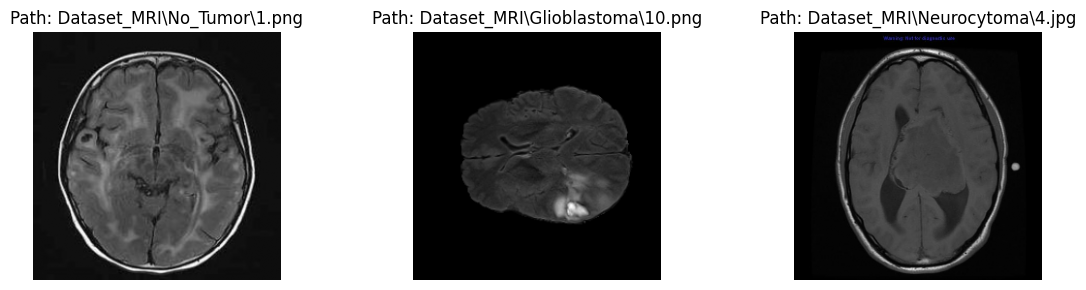

In [8]:
(8)
# Number of images to display
num_images_to_display = 3

# Randomly select a batch
batch_index = np.random.randint(0, len(train_generator))
X_batch, y_batch = train_generator.__getitem__(batch_index)

# Randomly select images from the batch
selected_indices = np.random.choice(X_batch.shape[0], num_images_to_display, replace=False)

plt.figure(figsize=(12, 3))
for i, idx in enumerate(selected_indices):
    # Retrieve the file path for the current image
    image_path = train_generator.image_paths[train_generator.indexes[batch_index * train_generator.batch_size + idx]]

    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(X_batch[idx])
    plt.title(f"Path: {image_path}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Train-Data & Validation-Data

In [9]:
(9)
# Custom VGG16 Encoder
def custom_vgg16_encoder(input_tensor):
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    s1 = x  # Save the feature map for decoder
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    s2 = x  # Save the feature map for decoder
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    s3 = x  # Save the feature map for decoder

    return s3, s2, s1

# Custom U-Net Decoder
def custom_unet_decoder(conv4, conv3, conv2, conv1):
    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv4)
    u6 = layers.concatenate([u6, conv3], axis=-1)
    u6 = layers.BatchNormalization()(u6)
    u6 = layers.Activation('relu')(u6)
    u6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    u6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    u6 = layers.Dropout(0.5)(u6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = layers.concatenate([u7, conv2], axis=-1)
    u7 = layers.BatchNormalization()(u7)
    u7 = layers.Activation('relu')(u7)
    u7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    u7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    u7 = layers.Dropout(0.5)(u7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(u7)

    # Adjust the shape of conv1 to match the shape of u8
    conv1_adjusted = layers.Conv2D(128, (1, 1), activation='relu')(conv1)
    conv1_adjusted = layers.UpSampling2D(size=(2, 2))(conv1_adjusted)

    u8 = layers.concatenate([u8, conv1_adjusted], axis=-1)
    u8 = layers.BatchNormalization()(u8)
    u8 = layers.Activation('relu')(u8)
    u8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    u8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    u8 = layers.Dropout(0.5)(u8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = layers.BatchNormalization()(u9)
    u9 = layers.Activation('relu')(u9)
    u9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    u9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    u9 = layers.Dropout(0.5)(u9)
    return u9

# Build Custom UNet-VGG16 Model
def build_custom_unet_vgg16_for_rgb(input_shape, num_classes=7):
    inputs = tf.keras.layers.Input(input_shape)

    """ Encoder """
    s3, s2, s1 = custom_vgg16_encoder(inputs)

    """ Decoder (U-Net) """
    u_net_decoder_output = custom_unet_decoder(s3, s2, s1, s1)

    """ Output """
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(u_net_decoder_output)

    model = tf.keras.models.Model(inputs, outputs, name="Custom_RGB_Brain_Tumor_Segmentation_Model")
    return model

# Create the model instance for RGB input
custom_rgb_model = build_custom_unet_vgg16_for_rgb((256, 256, 3), num_classes=7)

# Compile the model
custom_rgb_model.compile(optimizer='adam', loss='focal_tversky_loss', metrics=['accuracy'])

# Display the model summary
custom_rgb_model.summary()





Model: "Custom_RGB_Brain_Tumor_Segmentation_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                    

Custom Loss Function

In [10]:
(10)
epsilon = 1e-5
smooth = 1

def categorical_tversky_index(y_true, y_pred, alpha=0.7):
    # Get the dynamic shape
    shape = tf.shape(y_true)
    y_true = K.reshape(y_true, [-1, shape[-3], shape[-2], shape[-1]])
    y_pred = K.reshape(y_pred, [-1, shape[-3], shape[-2], shape[-1]])

    # Calculate Tversky index for each pixel and then average over all pixels
    true_positives = K.sum(y_true * y_pred, axis=[1, 2])
    false_negatives = K.sum(y_true * (1 - y_pred), axis=[1, 2])
    false_positives = K.sum((1 - y_true) * y_pred, axis=[1, 2])

    tversky_index = (true_positives + smooth) / (true_positives + alpha * false_negatives + (1 - alpha) * false_positives + smooth)
    return K.mean(tversky_index)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tversky_index = categorical_tversky_index(y_true, y_pred)
    return K.pow((1 - tversky_index), gamma)

# Custom loss function
def modified_categorical_crossentropy(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred) + (1 - categorical_tversky_index(y_true, y_pred))



Checkpoints

In [16]:
(11)
class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, csv_filename="Model_Weights/training_history.csv"):
        super(SaveHistoryCallback, self).__init__()
        self.csv_filename = csv_filename
        self.epoch_history = []
        # Load existing history if it exists to maintain continuity
        if os.path.exists(self.csv_filename):
            self.epoch_history = pd.read_csv(self.csv_filename).to_dict('records')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Adjust epoch number based on existing records
        current_epoch = epoch + 1 if not self.epoch_history else self.epoch_history[-1].get('epoch', epoch) + 1
        logs['epoch'] = current_epoch
        self.epoch_history.append(logs)
        # Ensure 'epoch' is the first column
        df = pd.DataFrame(self.epoch_history)
        cols = ['epoch'] + [col for col in df.columns if col != 'epoch']
        df = df[cols]
        # Save updated history ensuring 'epoch' is first
        df.to_csv(self.csv_filename, index=False)

# Instantiate callbacks
csv_filename = "Model_Weights/training_history.csv"
save_history_callback = SaveHistoryCallback(csv_filename)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
checkpointer = ModelCheckpoint(filepath="Model_Weights/brain_tumor_model_weights.hdf5", verbose=1, save_best_only=True, save_weights_only=False, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=0.000001, verbose=1)

# Assuming custom_rgb_model is already defined
adam = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.1)
custom_rgb_model.compile(optimizer=adam, loss=focal_tversky_loss, metrics=['accuracy'])



setup epoch latest value

In [17]:
(12)
# Check and read the existing CSV, if available
if os.path.exists(csv_filename):
    existing_df = pd.read_csv(csv_filename)
    # Ensure 'epoch' is the first column by reordering if it's not
    if 'epoch' in existing_df.columns:
        cols = ['epoch'] + [col for col in existing_df.columns if col != 'epoch']
        existing_df = existing_df[cols]
    existing_df.to_csv(csv_filename, index=False)
else:
    # If the CSV doesn't exist, no action is needed here
    pass

Loading the model checkpoint

In [18]:
model_path = "Model_Weights/brain_tumor_model_weights.hdf5"
if os.path.exists(model_path):
    custom_rgb_model = load_model(model_path, custom_objects={'focal_tversky_loss': focal_tversky_loss})
    print("Model loaded successfully.")
else:
    print("Starting training from scratch.")

Model loaded successfully.


Epochs

In [19]:
(13)
# Total number of epochs to train
total_epochs = 400
# Train the model with the callbacks
history = custom_rgb_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=total_epochs,
    callbacks=[early_stopping, reduce_lr, checkpointer, save_history_callback],
    verbose=1
)

# Access the entire training history
entire_training_history = save_history_callback.epoch_history


Epoch 1/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1540 
Epoch 1: val_loss improved from inf to 0.98938, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 76s 39s/step - loss: 0.9798 - accuracy: 0.1540 - val_loss: 0.9894 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 28.0000
Epoch 2/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1540 
Epoch 2: val_loss improved from 0.98938 to 0.98938, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1540 - val_loss: 0.9894 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 29.0000
Epoch 3/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1541 
Epoch 3: val_loss improved from 0.98938 to 0.98938, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1541 - val_loss: 0.9894 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 30.0000
Epoch 4/400
2/2 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.1541 
Epoch 4: val_loss improved from 0.98938 to 0.98937, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9799 - accuracy: 0.1541 - val_loss: 0.9894 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 31.0000
Epoch 5/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1539 
Epoch 5: val_loss improved from 0.98937 to 0.98937, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 37s/step - loss: 0.9798 - accuracy: 0.1539 - val_loss: 0.9894 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 32.0000
Epoch 6/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1543 
Epoch 6: val_loss improved from 0.98937 to 0.98937, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1543 - val_loss: 0.9894 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 33.0000
Epoch 7/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1542 
Epoch 7: val_loss improved from 0.98937 to 0.98937, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1542 - val_loss: 0.9894 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 34.0000
Epoch 8/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1538 
Epoch 8: val_loss improved from 0.98937 to 0.98936, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1538 - val_loss: 0.9894 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 35.0000
Epoch 9/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1542 
Epoch 9: val_loss improved from 0.98936 to 0.98936, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1542 - val_loss: 0.9894 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 36.0000
Epoch 10/400
2/2 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.1544 
Epoch 10: val_loss improved from 0.98936 to 0.98936, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9799 - accuracy: 0.1544 - val_loss: 0.9894 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 37.0000
Epoch 11/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1540 
Epoch 11: val_loss improved from 0.98936 to 0.98936, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1540 - val_loss: 0.9894 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 38.0000
Epoch 12/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1541 
Epoch 12: val_loss improved from 0.98936 to 0.98936, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1541 - val_loss: 0.9894 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 39.0000
Epoch 13/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1541 
Epoch 13: val_loss improved from 0.98936 to 0.98936, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1541 - val_loss: 0.9894 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 40.0000
Epoch 14/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1537 
Epoch 14: val_loss improved from 0.98936 to 0.98935, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 37s/step - loss: 0.9798 - accuracy: 0.1537 - val_loss: 0.9894 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 41.0000
Epoch 15/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1538 
Epoch 15: val_loss improved from 0.98935 to 0.98935, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 37s/step - loss: 0.9798 - accuracy: 0.1538 - val_loss: 0.9894 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 42.0000
Epoch 16/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1540 
Epoch 16: val_loss improved from 0.98935 to 0.98935, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1540 - val_loss: 0.9894 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 43.0000
Epoch 17/400
2/2 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.1545 
Epoch 17: val_loss improved from 0.98935 to 0.98935, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9799 - accuracy: 0.1545 - val_loss: 0.9894 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 44.0000
Epoch 18/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1541 
Epoch 18: val_loss improved from 0.98935 to 0.98935, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1541 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 45.0000
Epoch 19/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1540 
Epoch 19: val_loss improved from 0.98935 to 0.98935, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1540 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 46.0000
Epoch 20/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1540 
Epoch 20: val_loss improved from 0.98935 to 0.98935, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1540 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 47.0000
Epoch 21/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1543 
Epoch 21: val_loss improved from 0.98935 to 0.98934, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1543 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 48.0000
Epoch 22/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1539 
Epoch 22: val_loss improved from 0.98934 to 0.98934, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1539 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 49.0000
Epoch 23/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1544 
Epoch 23: val_loss improved from 0.98934 to 0.98934, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1544 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 50.0000
Epoch 24/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1539 
Epoch 24: val_loss improved from 0.98934 to 0.98934, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1539 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 51.0000
Epoch 25/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1542 
Epoch 25: val_loss improved from 0.98934 to 0.98934, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1542 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 52.0000
Epoch 26/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1540 
Epoch 26: val_loss improved from 0.98934 to 0.98934, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1540 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 53.0000
Epoch 27/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1542 
Epoch 27: val_loss improved from 0.98934 to 0.98933, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1542 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 54.0000
Epoch 28/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1542 
Epoch 28: val_loss improved from 0.98933 to 0.98933, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1542 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 55.0000
Epoch 29/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1544 
Epoch 29: val_loss improved from 0.98933 to 0.98933, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1544 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 56.0000
Epoch 30/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1537 
Epoch 30: val_loss improved from 0.98933 to 0.98933, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1537 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 57.0000
Epoch 31/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1543 
Epoch 31: val_loss improved from 0.98933 to 0.98933, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1543 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 58.0000
Epoch 32/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1541 
Epoch 32: val_loss improved from 0.98933 to 0.98932, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1541 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 59.0000
Epoch 33/400
2/2 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.1543 
Epoch 33: val_loss improved from 0.98932 to 0.98932, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9799 - accuracy: 0.1543 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 60.0000
Epoch 34/400
2/2 [==============================] - ETA: 0s - loss: 0.9797 - accuracy: 0.1539 
Epoch 34: val_loss improved from 0.98932 to 0.98932, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9797 - accuracy: 0.1539 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 61.0000
Epoch 35/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1540 
Epoch 35: val_loss improved from 0.98932 to 0.98932, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1540 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 62.0000
Epoch 36/400
2/2 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.1542 
Epoch 36: val_loss improved from 0.98932 to 0.98932, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9799 - accuracy: 0.1542 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 63.0000
Epoch 37/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1543 
Epoch 37: val_loss improved from 0.98932 to 0.98932, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1543 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 64.0000
Epoch 38/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1542 
Epoch 38: val_loss improved from 0.98932 to 0.98931, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1542 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 65.0000
Epoch 39/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1540 
Epoch 39: val_loss improved from 0.98931 to 0.98931, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1540 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 66.0000
Epoch 40/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1539 
Epoch 40: val_loss improved from 0.98931 to 0.98931, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1539 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 67.0000
Epoch 41/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1538 
Epoch 41: val_loss improved from 0.98931 to 0.98931, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1538 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 68.0000
Epoch 42/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1540 
Epoch 42: val_loss improved from 0.98931 to 0.98931, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 70s 38s/step - loss: 0.9798 - accuracy: 0.1540 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 69.0000
Epoch 43/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1539 
Epoch 43: val_loss improved from 0.98931 to 0.98930, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1539 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 70.0000
Epoch 44/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1540 
Epoch 44: val_loss improved from 0.98930 to 0.98930, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1540 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 71.0000
Epoch 45/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1542 
Epoch 45: val_loss improved from 0.98930 to 0.98930, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 37s/step - loss: 0.9798 - accuracy: 0.1542 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 72.0000
Epoch 46/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1542 
Epoch 46: val_loss improved from 0.98930 to 0.98930, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1542 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 73.0000
Epoch 47/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1541 
Epoch 47: val_loss improved from 0.98930 to 0.98930, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 71s 37s/step - loss: 0.9798 - accuracy: 0.1541 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 74.0000
Epoch 48/400
2/2 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.1542 
Epoch 48: val_loss improved from 0.98930 to 0.98930, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9799 - accuracy: 0.1542 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 75.0000
Epoch 49/400
2/2 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.1545 
Epoch 49: val_loss improved from 0.98930 to 0.98929, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 38s/step - loss: 0.9799 - accuracy: 0.1545 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 76.0000
Epoch 50/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1540 
Epoch 50: val_loss improved from 0.98929 to 0.98929, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1540 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 77.0000
Epoch 51/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1539 
Epoch 51: val_loss improved from 0.98929 to 0.98929, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1539 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 78.0000
Epoch 52/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1543 
Epoch 52: val_loss improved from 0.98929 to 0.98929, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 72s 37s/step - loss: 0.9798 - accuracy: 0.1543 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 79.0000
Epoch 53/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1542 
Epoch 53: val_loss improved from 0.98929 to 0.98929, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1542 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 80.0000
Epoch 54/400
2/2 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.1543 
Epoch 54: val_loss improved from 0.98929 to 0.98928, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9799 - accuracy: 0.1543 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 81.0000
Epoch 55/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1539 
Epoch 55: val_loss improved from 0.98928 to 0.98928, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1539 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 82.0000
Epoch 56/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1541 
Epoch 56: val_loss improved from 0.98928 to 0.98928, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1541 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 83.0000
Epoch 57/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1541 
Epoch 57: val_loss improved from 0.98928 to 0.98928, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1541 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 84.0000
Epoch 58/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1541 
Epoch 58: val_loss improved from 0.98928 to 0.98928, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 37s/step - loss: 0.9798 - accuracy: 0.1541 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 85.0000
Epoch 59/400
2/2 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.1539 
Epoch 59: val_loss improved from 0.98928 to 0.98928, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9799 - accuracy: 0.1539 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 86.0000
Epoch 60/400
2/2 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.1543 
Epoch 60: val_loss improved from 0.98928 to 0.98928, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 38s/step - loss: 0.9799 - accuracy: 0.1543 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 87.0000
Epoch 61/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1541 
Epoch 61: val_loss improved from 0.98928 to 0.98927, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 70s 38s/step - loss: 0.9798 - accuracy: 0.1541 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 88.0000
Epoch 62/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1540 
Epoch 62: val_loss improved from 0.98927 to 0.98927, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 37s/step - loss: 0.9798 - accuracy: 0.1540 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 89.0000
Epoch 63/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1541 
Epoch 63: val_loss improved from 0.98927 to 0.98927, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 37s/step - loss: 0.9798 - accuracy: 0.1541 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 90.0000
Epoch 64/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1543 
Epoch 64: val_loss improved from 0.98927 to 0.98927, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 37s/step - loss: 0.9798 - accuracy: 0.1543 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 91.0000
Epoch 65/400
2/2 [==============================] - ETA: 0s - loss: 0.9797 - accuracy: 0.1540 
Epoch 65: val_loss improved from 0.98927 to 0.98927, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9797 - accuracy: 0.1540 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 92.0000
Epoch 66/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1541 
Epoch 66: val_loss improved from 0.98927 to 0.98927, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1541 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 93.0000
Epoch 67/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1539 
Epoch 67: val_loss improved from 0.98927 to 0.98926, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 37s/step - loss: 0.9798 - accuracy: 0.1539 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 94.0000
Epoch 68/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1544 
Epoch 68: val_loss improved from 0.98926 to 0.98926, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1544 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 95.0000
Epoch 69/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1544 
Epoch 69: val_loss improved from 0.98926 to 0.98926, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1544 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 96.0000
Epoch 70/400
2/2 [==============================] - ETA: 0s - loss: 0.9797 - accuracy: 0.1540 
Epoch 70: val_loss improved from 0.98926 to 0.98926, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 37s/step - loss: 0.9797 - accuracy: 0.1540 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 97.0000
Epoch 71/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1539 
Epoch 71: val_loss improved from 0.98926 to 0.98926, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1539 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 98.0000
Epoch 72/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1541 
Epoch 72: val_loss improved from 0.98926 to 0.98926, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 37s/step - loss: 0.9798 - accuracy: 0.1541 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 99.0000
Epoch 73/400
2/2 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.1541 
Epoch 73: val_loss improved from 0.98926 to 0.98925, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9799 - accuracy: 0.1541 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 100.0000
Epoch 74/400
2/2 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.1544 
Epoch 74: val_loss improved from 0.98925 to 0.98925, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9799 - accuracy: 0.1544 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 101.0000
Epoch 75/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1542 
Epoch 75: val_loss improved from 0.98925 to 0.98925, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1542 - val_loss: 0.9893 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 102.0000
Epoch 76/400
2/2 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.1544 
Epoch 76: val_loss improved from 0.98925 to 0.98925, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 37s/step - loss: 0.9799 - accuracy: 0.1544 - val_loss: 0.9892 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 103.0000
Epoch 77/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1540 
Epoch 77: val_loss improved from 0.98925 to 0.98925, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1540 - val_loss: 0.9892 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 104.0000
Epoch 78/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1538 
Epoch 78: val_loss improved from 0.98925 to 0.98925, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1538 - val_loss: 0.9892 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 105.0000
Epoch 79/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1541 
Epoch 79: val_loss improved from 0.98925 to 0.98924, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1541 - val_loss: 0.9892 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 106.0000
Epoch 80/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1544 
Epoch 80: val_loss improved from 0.98924 to 0.98924, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1544 - val_loss: 0.9892 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 107.0000
Epoch 81/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1539 
Epoch 81: val_loss improved from 0.98924 to 0.98924, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9798 - accuracy: 0.1539 - val_loss: 0.9892 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 108.0000
Epoch 82/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1540 
Epoch 82: val_loss improved from 0.98924 to 0.98924, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1540 - val_loss: 0.9892 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 109.0000
Epoch 83/400
2/2 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.1540 
Epoch 83: val_loss improved from 0.98924 to 0.98924, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 68s 37s/step - loss: 0.9799 - accuracy: 0.1540 - val_loss: 0.9892 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 110.0000
Epoch 84/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1542 
Epoch 84: val_loss improved from 0.98924 to 0.98924, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 0.9798 - accuracy: 0.1542 - val_loss: 0.9892 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 111.0000
Epoch 85/400
2/2 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.1540 
Epoch 85: val_loss improved from 0.98924 to 0.98923, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 75s 40s/step - loss: 0.9798 - accuracy: 0.1540 - val_loss: 0.9892 - val_accuracy: 0.5850 - lr: 1.0000e-06 - epoch: 112.0000
Epoch 86/400


KeyboardInterrupt: 

Predictioned output Pending 

In [ ]:
#